In [10]:
import sys
import os
import src.analyze as analyze 
import src.stats_utils as stats_utils
import src.mixtures as mixtures
import src.better_optimiation as bopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import src.EM as EM
from src.EM import compute_estimate, compute_estimate_stable, compute_p_at_ks, compute_estimates_better_mixture
import src.better_em as BEM
import heapq
import src.bem_geometric as bemg
from src.bem_geometric import compute_estimates_better_three_param_geometric, compute_estimates_three_param

Set model and number of samples

In [11]:
model_name = 'Pythia 1B'#['Claude 3.5 Opus', 'Claude 3.5 Sonnet', 'GPT4o', 'GPT4o Mini', 'Gemini 1.5 Flash', 'Gemini 1.5 Pro', 'Llama 3 8B IT']
samples = 50
#define the ks that we will try to predict
ks = np.array(np.logspace(np.log10(1), np.log10(10000), num=100))

Load all data for monkeys power laws

In [12]:
#get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

#this tells us whether each attempt was a success or failure -- I don't think it adds any 
#value given that the attempts were independent
individual_data = analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()

Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


Number of total samples is missing-- fill this in

In [1087]:
#label the number of total samples and compute the number of correct attempts for each problem
data['Num. Samples Total'] = data['Scaling Parameter'].max()
data['Num. Samples Correct'] = data['Score']*data['Num. Samples Total']
data = data[data['Scaling Parameter'] == 1]

In [76]:
# If you also want to include Benchmark in the grouping:
model_problem_benchmark_summary = individual_data.groupby(['Model', 'Problem Idx', 'Benchmark']).agg(
    Total_Successes=('Score', 'sum'),
    Total_Attempts=('Score', 'count')
).reset_index()

model_problem_benchmark_summary['Num. Samples Correct'] = (
    model_problem_benchmark_summary['Total_Successes'] 
)

model_problem_benchmark_summary['Num. Samples Total'] = (
    model_problem_benchmark_summary['Total_Successes'] 
)
print("\nWith Benchmark included:")
print(model_problem_benchmark_summary)


With Benchmark included:
          Model  Problem Idx Benchmark  Total_Successes  Total_Attempts  Num. Samples Correct  Num. Samples Total
0    Pythia 12B           82      MATH            667.0           10000                 667.0               667.0
1    Pythia 12B          142      MATH            464.0           10000                 464.0               464.0
2    Pythia 12B          188      MATH            832.0           10000                 832.0               832.0
3    Pythia 12B          201      MATH            933.0           10000                 933.0               933.0
4    Pythia 12B          240      MATH            833.0           10000                 833.0               833.0
..          ...          ...       ...              ...             ...                   ...                 ...
891  Pythia 70M         4861      MATH            539.0           10000                 539.0               539.0
892  Pythia 70M         4895      MATH            780.0       

In [73]:
individual_data.groupby(['Model', 'Problem Idx'])['Problem Idx', 'Score', 'Model'].sum().first()

TypeError: NDFrame.first() missing 1 required positional argument: 'offset'

In [20]:
probs = np.random.uniform(size = problem_count)

In [68]:
final_data = individual_data.copy()
final_data['']

Choose which model to analyze

In [46]:
probs = np.random.uniform(0, 0.10, size = problem_count)
for i, problem_index in enumerate(individual_data['Problem Idx'].unique()):
    mask = (individual_data['Problem Idx'] == problem_index)
    individual_data.loc[mask, 'Score'] = np.random.binomial(n=1, p = probs[i], size=mask.sum())

In [65]:
data.head()

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930


Collect a subset of the data that we use as the training set for prediction

In [47]:
model_ind_full = individual_data[(individual_data['Model'] == model_name)]
# If you want to shuffle within each Problem Idx group
def shuffle_group(group):
    group = group.copy()
    group['Score'] = np.random.permutation(group['Score'])
    return group

model_ind_full = model_ind_full.groupby('Problem Idx').apply(shuffle_group).reset_index(drop=True)
model_ind = model_ind_full[model_ind_full['Attempt Idx'] <= samples]
model_ind['Num. Samples Correct'] = model_ind.groupby('Problem Idx')['Score'].transform('sum')
model_ind['Num. Samples Total'] = samples
smaller_pythia12_math = model_ind

/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_6064/3660908005.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_ind_full = model_ind_full.groupby('Problem Idx').apply(shuffle_group).reset_index(drop=True)
/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_6064/3660908005.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_ind['Num. Samples Correct'] = model_ind.groupby('Problem Idx')['Score'].transform('sum')
/var/folders

In [48]:
smaller_pythia12_math = smaller_pythia12_math.groupby('Problem Idx').first()

In [49]:
smaller_pythia12_math.head()

,Attempt Idx,Score,Benchmark,Model,Num. Samples Correct,Num. Samples Total
Problem Idx,,,,,,
82,1,0.0,MATH,Pythia 1B,7.0,50
142,1,0.0,MATH,Pythia 1B,3.0,50
188,1,0.0,MATH,Pythia 1B,4.0,50
201,1,0.0,MATH,Pythia 1B,8.0,50
240,1,0.0,MATH,Pythia 1B,4.0,50


Fit all methods that don't involve mixtures

In [50]:
# smaller_beta_2_params = analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(smaller_pythia12_math)
# smaller_beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(smaller_pythia12_math)
#smaller_beta_3_params = analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(smaller_pythia12_math)
# smaller_beta_3_params_stable = bopt.fit_beta_binomial_three_parameters_stable(smaller_pythia12_math)
smaller_beta_3_discretized_params = analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(smaller_pythia12_math)

In [51]:
# smaller_beta_3_params_stable

Compute the original OpenAI method

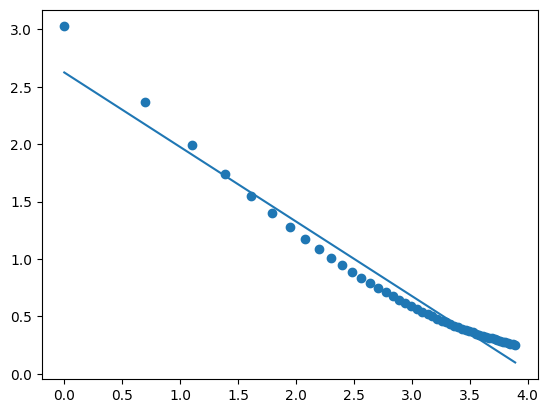

In [52]:
#original estimator
ks_fit = np.array([i for i in range(1, samples)])
pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(smaller_pythia12_math, ks_fit)
pass_at_ks = pass_at_ks.groupby('Scaling Parameter')['Score'].mean()
model = LinearRegression(fit_intercept=True)
model.fit(np.log(ks_fit).reshape(-1,1), -np.log(pass_at_ks))
plt.scatter(np.log(ks_fit), -np.log(pass_at_ks))
plt.plot(np.log(ks_fit), model.predict(np.log(ks_fit).reshape(-1,1)))

Compute beta-binomial mixture parameters

In [53]:
# n_distr = 1
# beta_mixture = BEM.beta_binom_mixture(n_distr=n_distr, num_successes= smaller_pythia12_math['Num. Samples Correct'], num_trials=smaller_pythia12_math['Num. Samples Total'])
# beta_mixture_params = beta_mixture.fit_mixture()
#beta_mixture_params = EM.fit_beta_binomial_mixture_em(smaller_pythia12_math['Num. Samples Total'], smaller_pythia12_math['Num. Samples Correct'], n_distr)

Sample efficiently by always sampling the question with the lowest success probability so far

In [54]:
individual_data_model = model_ind_full

heap = []
heapq.heapify(heap)
budget = samples*len(pythia12_math)
results = []
for ele in individual_data_model['Problem Idx'].unique():
    heapq.heappush(heap, (0, ele))
total_samples = 0
while total_samples < budget:
    total_samples += 1
    attempts, index = heapq.heappop(heap)
    attempt_index = attempts + 1
    
    # Check if this attempt exists
    filtered_data = individual_data_model[
        (individual_data_model['Problem Idx'] == index) & 
        (individual_data_model['Attempt Idx'] == attempt_index)
    ]
    
    if filtered_data.empty:
        continue  # Skip if no data for this attempt
        
    score = filtered_data['Score'].iloc[0]
    attempts += 1
    
    if score == 0:
        heapq.heappush(heap, (attempts, index))  # Fixed: use 'index' not 'ele'
    else:
        results.append({'Problem Idx': index, 'Num. Samples Total': attempts, 'Num. Samples Correct': 1})
while heap:
    attempts, index = heapq.heappop(heap)
    results.append({'Problem Idx': index, 'Num. Samples Total': attempts, 'Num. Samples Correct': 0})
efficient_data = pd.DataFrame(results)

NameError: name 'pythia12_math' is not defined

In [55]:
budget

NameError: name 'budget' is not defined

In [56]:
individual_data_model[individual_data_model['Problem Idx'] == 131]

,Problem Idx,Attempt Idx,Score,Benchmark,Model


In [57]:
#version with thompson sampling
individual_data_model = model_ind_full

heap = []
heapq.heapify(heap)
budget = samples*len(pythia12_math)
results = []
starting_distr = [] #(1, 1, 0, index) for index in individual_data_model['Problem Idx'].unique()]

total_samples = 0
for problem in individual_data_model['Problem Idx'].unique():

    #get first sample from every problem so that we can still estimate
    filtered_data = individual_data_model[
        (individual_data_model['Problem Idx'] == problem) & 
        (individual_data_model['Attempt Idx'] == 1)
    ]
    score = filtered_data['Score'].iloc[0]
    #alpha, beta, attempts
    starting_distr.append((1+score, 2-score, 1, problem))
    total_samples += 1    


while total_samples < budget:
    draws = []
    for i, ele in enumerate(starting_distr):
        draws.append(np.random.beta(ele[0], ele[1]))
    # draws.append([-1]) # just so that the median is in the dataframe
    draws = np.array(draws)
    med = np.median(draws)
    print(draws)
    print(med)
    m = np.argmax(draws == med)
    print(m)

    alpha, beta, attempts, index = starting_distr[m]

    
    #choose the one with the minimum sample value
        
    attempts += 1
    # Check if this attempt exists
    filtered_data = individual_data_model[
        (individual_data_model['Problem Idx'] == index) & 
        (individual_data_model['Attempt Idx'] == attempts)
    ]

    
    if filtered_data.empty:
        print(f'problem index: {index}')
        print(f'attempt index: {attempts}')
        continue  # Skip if no data for this attempt
    else:
        total_samples +=1
            
        score = filtered_data['Score'].iloc[0]

        
        starting_distr[m] = (alpha + score, beta+ (1-score), attempts, index)
for ele in starting_distr:
    results.append({'Problem Idx': ele[-1], 'Num. Samples Total': ele[-2], 'Num. Samples Correct': ele[0]-1})
efficient_data = pd.DataFrame(results)


NameError: name 'pythia12_math' is not defined

In [58]:
print(len(draws))

NameError: name 'draws' is not defined

In [59]:
smaller_pythia12_math['Num. Samples Correct'].sum()

311.0

In [60]:
plt.hist(efficient_data['Num. Samples Total'], bins=100)

NameError: name 'efficient_data' is not defined

Fit geometric mixture

In [61]:
#beta 2 geometric
n_distr = 1
geom_mix = bemg.beta_geometric_mixture(n_distr=n_distr, num_successes = efficient_data['Num. Samples Correct'], num_trials = efficient_data['Num. Samples Total'])
# geom_params = geom_mix.fit_mixture()
geom_params = analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(efficient_data)
geom_preds = [compute_estimate(geom_params, k) for k in ks]
beta_std_params = analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(smaller_pythia12_math)
beta_std_preds = [compute_estimate(beta_std_params, k) for k in ks]
#beta 3 geometric
# smaller_beta_3_params_geometric_stable = bopt.fit_beta_binomial_three_parameters_stable(efficient_data)


NameError: name 'efficient_data' is not defined

Compute p@k estimates

In [62]:
pass_at_ks = compute_p_at_ks(pythia12_math, ks)

NameError: name 'pythia12_math' is not defined

Compute estimates for all methods

In [44]:
#openai regression predictions
X = ks.reshape(-1,1)
regression_predictions = np.exp(-model.predict(np.log(X)))
#beta discretized estimates
beta_estimates = [compute_estimate(smaller_beta_3_discretized_params, k) for k in ks] 
#2-param binomial mixture
# mixture_estimates = [compute_estimates_better_mixture(smaller_pythia12_math, beta_mixture_params, k, n_distr) for k in ks]
#3-param binomial 
# beta_3_stable_estimates_better = [compute_estimates_three_param(smaller_pythia12_math, smaller_beta_3_params_stable, k) for k in ks] 
#3-param geometric
# three_param_geom_estimates = [bemg.compute_estimates_better_three_param_geometric(efficient_data, smaller_beta_3_params_geometric_stable, k) for k in ks]
#2-param geometric
# geom_correct_estimates = [bemg.compute_estimates_better_mixture_geometric(efficient_data, geom_params, k, n_distr) for k in ks]

Make a graph of the fits

NameError: name 'geom_preds' is not defined

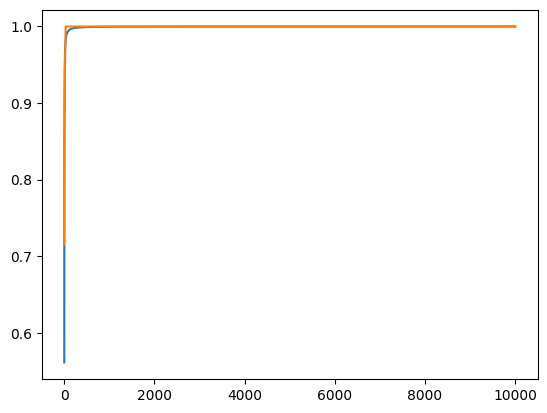

In [45]:

plt.plot(ks, beta_estimates, label = 'Discretized Beta')
# plt.plot(ks, mixture_estimates, label = 'Beta-Binomial')
plt.plot(ks, np.clip(regression_predictions, 0, 1), label = "Regression (clipped at 1)")
plt.plot(ks, np.clip(geom_preds, 0, 1), label = "Beta w Dynamic Sampling (Ours)", linewidth=4, color='red', linestyle='-', markeredgecolor='darkred')
plt.plot(ks, beta_std_preds, label = 'beta_std_preds')
# plt.plot(ks, beta_3_stable_estimates_better, label = 'Scaled Beta-Binomial')
# plt.plot(ks, three_param_geom_estimates, label = 'Scaled Beta w Dynamic Sampling')
plt.plot(ks, pass_at_ks, label = 'Pass@k Estimate w 10k Samples', linewidth=4, color='black', linestyle='dashed')
plt.title(f'Estimates of Pass@k for {model_name}')
plt.ylabel('Pass@k')
plt.xlabel('log(k)')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

(array([102.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         26.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

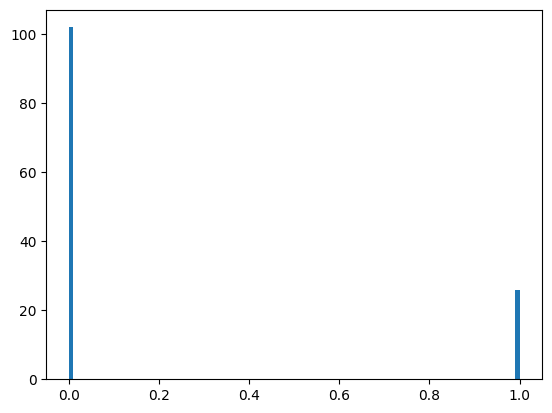

In [1107]:
plt.hist(efficient_data['Num. Samples Correct'], bins = 100)

In [1108]:
efficient_data['Num. Samples Correct'].sum()

26.0

In [1109]:
smaller_pythia12_math['Num. Samples Correct'].sum()

46.0

In [1110]:
def compute_error(pass_at_ks, estimates):
    return np.mean((pass_at_ks - estimates)**2)
    

In [1111]:
compute_error(beta_estimates, pass_at_ks)

0.0702611600487223

In [1112]:
compute_error(regression_predictions, pass_at_ks)

22.91201718394807

In [1113]:
individual_data.groupby(by = 'Problem Idx')['Score'].sum()

Problem Idx
82       548.0
142      243.0
188      412.0
201       10.0
240     8491.0
         ...  
4861     554.0
4895       0.0
4907       0.0
4975       1.0
4988       0.0
Name: Score, Length: 128, dtype: float32

In [1114]:
shuffled_data[shuffled_data['Problem Idx'] == 4]

NameError: name 'shuffled_data' is not defined

In [ ]:
individual_data[individual_data['Problem Idx'] == 4]

,Problem Idx,Attempt Idx,Score,Benchmark,Model


In [ ]:
data = pd.read_csv('notebooks/statistical_analysis/data/processed_data/jailbreaking_shuffled.csv')

In [ ]:
len(data)

4806

In [ ]:
smaller_beta_3_discretized_params

alpha                 0.013109
beta                  0.336569
loc                        0.0
scale                      0.3
neg_log_likelihood    0.151565
success                Success
dtype: object

In [ ]:
geom_params


alpha                  0.301948
beta                  25.522451
loc                    0.000000
scale                  1.000000
neg_log_likelihood     0.364781
aic                    4.729561
bic                   10.433622
Power Law Exponent     0.301948
dtype: float64

In [ ]:
def convert_geom_params(geom_params):
    ret = pd.Series({
        'alpha': geom_params['alpha_0'],
        'beta': geom_params['beta_0'],
        'loc': 0.0,
        'scale': 0
    })
    return ret

In [ ]:
convert_geom_params(geom_params)

KeyError: 'alpha_0'

In [ ]:
pd.read_csv('notebooks/statistical_analysis/data/processed_data/jailbreaking_shuffled_llama.csv')

,method,model,per_problem_budget,trial,1,2,3,4,5,6,...,2811,3237,3727,4291,4941,5689,6551,7543,8685,10000
0,discretized,Llama 3 8B IT,5,0,0.030458,0.047429,0.057775,0.064682,0.069684,0.073550,...,0.179333,0.181571,0.183801,0.186024,0.188242,0.190454,0.192661,0.194861,0.197055,0.199242
1,our_method,Llama 3 8B IT,5,0,0.092243,0.140461,0.160377,0.176101,0.185535,0.201839,...,0.929734,0.934212,0.938402,0.942325,0.946003,0.949445,0.952671,0.955690,0.958517,0.961164
2,regression,Llama 3 8B IT,5,0,0.051040,0.090902,0.127409,0.161896,0.194954,0.226915,...,37.994868,42.732022,48.053795,54.036512,60.770745,68.339604,76.858602,86.433724,97.199713,109.307624
3,pass@k,Llama 3 8B IT,5,0,0.051040,0.090902,0.127409,0.161896,0.194954,0.226915,...,37.994868,42.732022,48.053795,54.036512,60.770745,68.339604,76.858602,86.433724,97.199713,109.307624
4,discretized,Llama 3 8B IT,10,0,0.049425,0.079323,0.098953,0.112858,0.123362,0.131711,...,0.358560,0.362965,0.367336,0.371675,0.375989,0.380270,0.384526,0.388750,0.392944,0.397110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,pass@k,Llama 3 8B IT,85,0,0.044210,0.070426,0.092474,0.112188,0.130330,0.147310,...,9.167323,10.078775,11.079729,12.179761,13.390193,14.720115,16.183392,17.791161,19.558330,21.501178
68,discretized,Llama 3 8B IT,90,0,0.029643,0.056804,0.081753,0.104727,0.125934,0.145557,...,0.829226,0.836063,0.842620,0.848915,0.854963,0.860767,0.866343,0.871693,0.876829,0.881760
69,our_method,Llama 3 8B IT,90,0,0.123068,0.220658,0.299140,0.360637,0.409395,0.451783,...,0.990169,0.991519,0.992682,0.993687,0.994555,0.995304,0.995950,0.996508,0.996988,0.997403
70,regression,Llama 3 8B IT,90,0,0.041145,0.065846,0.086694,0.105376,0.122598,0.138739,...,8.993718,9.897176,10.890282,11.982710,13.185900,14.509104,15.966353,17.568999,19.332186,21.272471
